In [1]:
!pip install tensorflow==2.9.1
import tensorflow as tf
print('\u2022 Using TensorFlow Version:', tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 135.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 126.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting u

• Using TensorFlow Version: 2.9.1


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import save_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_dir = "/content/drive/MyDrive/skin_type/train"
validation_dir = "/content/drive/MyDrive/skin_type/validation"

# Data Exploration

In [6]:
# Generate data paths with labels for train dataset
train_filepaths = []
train_labels = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        fpath = os.path.join(root, file)
        train_filepaths.append(fpath)
        train_labels.append(os.path.basename(root))

# Create train dataframe
train_df = pd.DataFrame({'filepaths': train_filepaths, 'labels': train_labels})

# Split train dataframe into train and validation
labels = train_df['labels']
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=9, stratify=labels)

# Generate data paths with labels for test dataset
test_filepaths = []
test_labels = []

for root, dirs, files in os.walk(validation_dir):
    for file in files:
        fpath = os.path.join(root, file)
        test_filepaths.append(fpath)
        test_labels.append(os.path.basename(root))

# Create test dataframe
test_df = pd.DataFrame({'filepaths': test_filepaths, 'labels': test_labels})

In [7]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.0,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
valid_test_datagen  = ImageDataGenerator( rescale = 1.0/255.0 )

# Flow training, validation, and test images in batches of 40 using generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col= 'filepaths', 
                                                    y_col= 'labels',
                                                    batch_size=40,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    shuffle= True,
                                                    color_mode='rgb')   

validation_generator =  valid_test_datagen.flow_from_dataframe(valid_df,
                                                        x_col= 'filepaths', 
                                                        y_col= 'labels',
                                                        batch_size=40,
                                                        class_mode='categorical',
                                                        target_size=(224, 224),
                                                        shuffle= True,
                                                        color_mode='rgb')

test_generator =  valid_test_datagen.flow_from_dataframe(test_df,
                                                        x_col= 'filepaths', 
                                                        y_col= 'labels',
                                                        batch_size=40,
                                                        class_mode='categorical',
                                                        target_size=(224, 224),
                                                        shuffle= False,
                                                        color_mode='rgb')



Found 411 validated image filenames belonging to 3 classes.
Found 103 validated image filenames belonging to 3 classes.
Found 128 validated image filenames belonging to 3 classes.


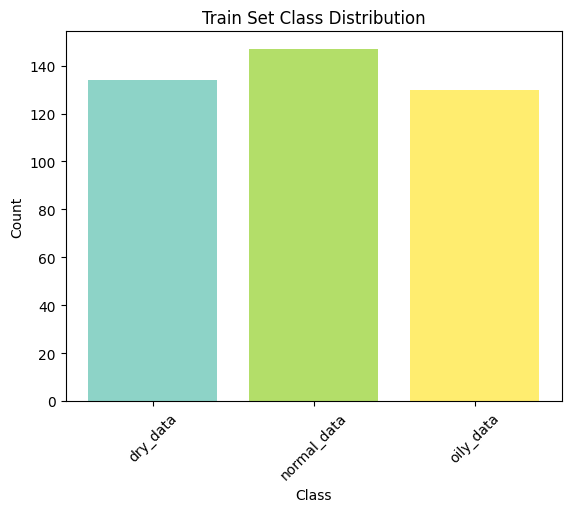

In [8]:
def visualize_class_distribution(generator, title):
    labels = generator.classes
    class_names = list(generator.class_indices.keys())
    class_counts = [labels.count(cls) for cls in range(len(class_names))]
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

    plt.bar(class_names, class_counts, color=colors)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

visualize_class_distribution(train_generator, 'Train Set Class Distribution')


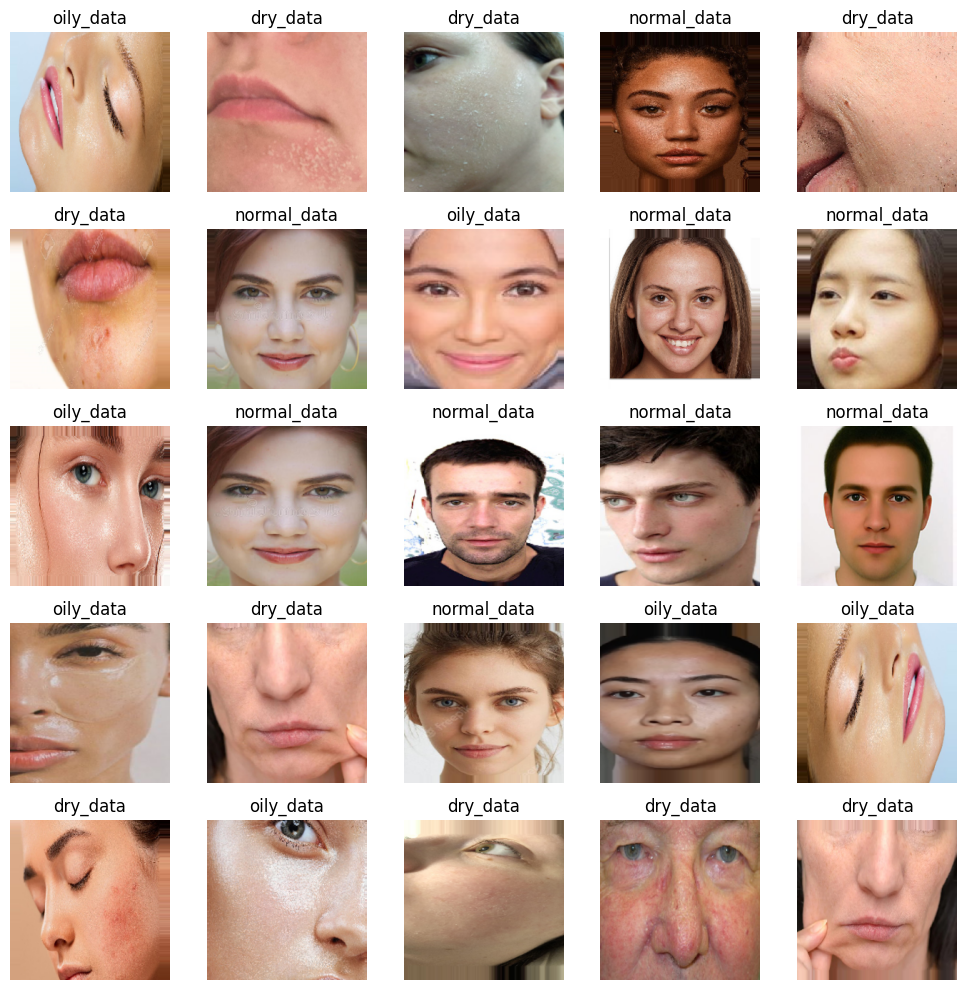

In [9]:
def display_images_with_labels(generator):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.ravel()

    classes = generator.class_indices
    classes = list(classes.keys())

    for i in range(25):
        images, labels = generator.next()
        image = images[0]
        label = labels[0]
        label_index = label.argmax()

        axes[i].imshow(image)
        axes[i].set_title(classes[label_index])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display images with labels from the train set
display_images_with_labels(train_generator)

# Model Training

In [10]:
base_model = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2"

image_shape = (224, 224, 3)

def create_model(base_model, num_classes=3):

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(base_model,
                                           trainable = False,  
                                           name="efficientnet_v2_b0",
                                           input_shape=image_shape) 

  model = tf.keras.Sequential([
    feature_extractor_layer, 
    tf.keras.layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    tf.keras.layers.Dense(64, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    tf.keras.layers.Dropout(rate= 0.45, seed= 123),
    tf.keras.layers.Dense(num_classes, activation= 'softmax')
  ])
  return model

In [11]:
# Create model
model = create_model(base_model, num_classes=3)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=Adamax(learning_rate= 0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasLa  (None, 1280)             5919312   
 yer)                                                            
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6,006,611
Trainable params: 84,739
Non-tra

In [12]:
history = model.fit(train_generator, epochs=20,
                    validation_data=validation_generator, shuffle= False)

Epoch 1/20
11/11 [==============================] - 41s 3s/step - loss: 3.0905 - accuracy: 0.6204 - val_loss: 2.7113 - val_accuracy: 0.8058
Epoch 2/20
11/11 [==============================] - 23s 2s/step - loss: 2.6058 - accuracy: 0.7932 - val_loss: 2.5584 - val_accuracy: 0.8738
Epoch 3/20
11/11 [==============================] - 23s 2s/step - loss: 2.4062 - accuracy: 0.8759 - val_loss: 2.4538 - val_accuracy: 0.8544
Epoch 4/20
11/11 [==============================] - 25s 2s/step - loss: 2.3214 - accuracy: 0.8783 - val_loss: 2.3834 - val_accuracy: 0.8544
Epoch 5/20
11/11 [==============================] - 24s 2s/step - loss: 2.2833 - accuracy: 0.8929 - val_loss: 2.3180 - val_accuracy: 0.8641
Epoch 6/20
11/11 [==============================] - 22s 2s/step - loss: 2.2315 - accuracy: 0.8881 - val_loss: 2.2481 - val_accuracy: 0.8641
Epoch 7/20
11/11 [==============================] - 24s 2s/step - loss: 2.1299 - accuracy: 0.9173 - val_loss: 2.1891 - val_accuracy: 0.8835
Epoch 8/20
11/11 [==

#Evaluation

In [13]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = model.evaluate(validation_generator, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 10s 7s/step - loss: 1.6148 - accuracy: 0.9625
Train Loss:  1.5982253551483154
Train Accuracy:  0.9750000238418579
--------------------
Validation Loss:  1.7669700384140015
Validation Accuracy:  0.9125000238418579
--------------------
Test Loss:  1.6148426532745361
Test Accuracy:  0.9624999761581421


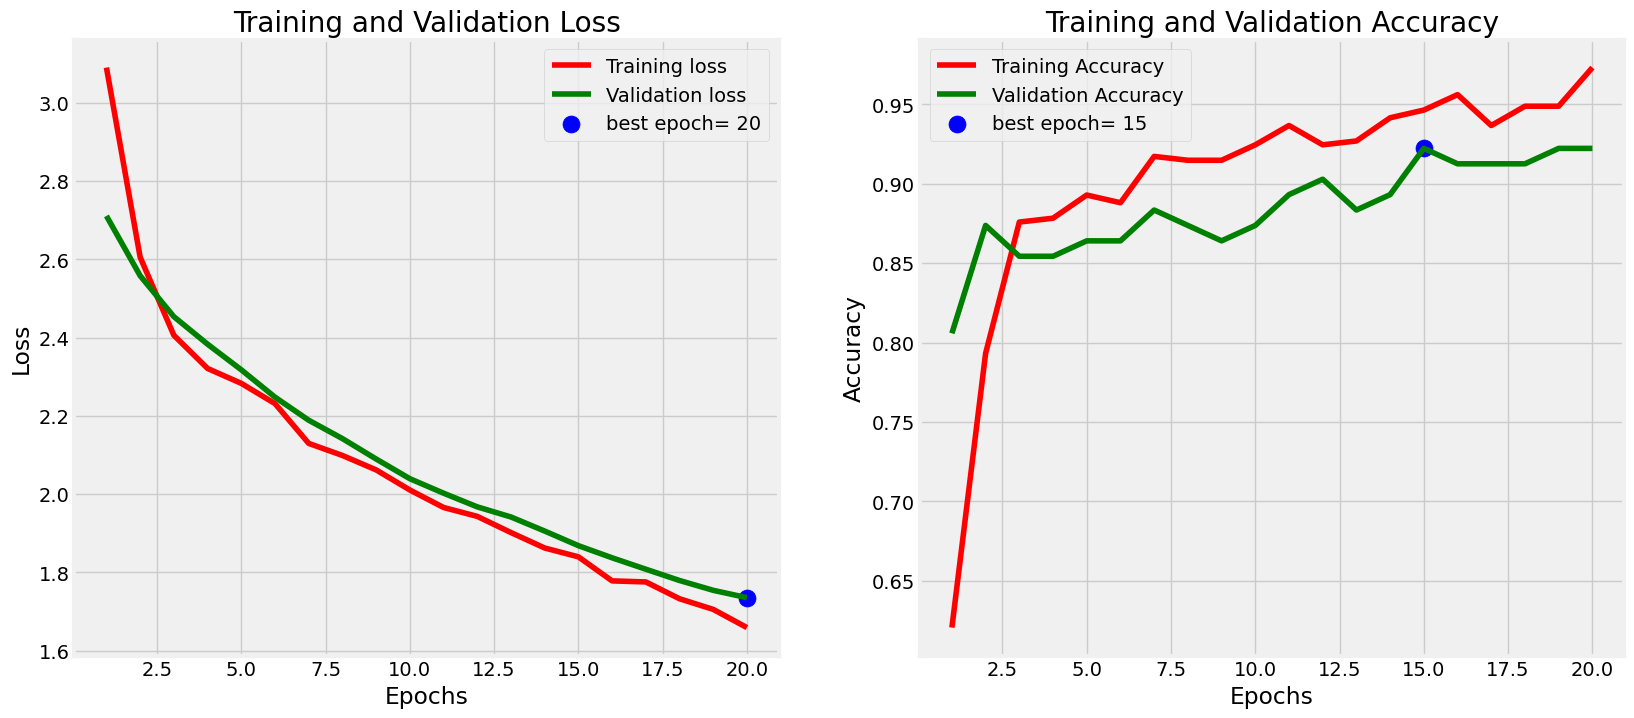

In [14]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

plot_training(history)

In [15]:
preds = model.predict_generator(test_generator)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-15-f47d97fbe6a6>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1]


In [16]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[42  0  0]
 [ 0 42  4]
 [ 0  3 37]]
              precision    recall  f1-score   support

    dry_data       1.00      1.00      1.00        42
 normal_data       0.93      0.91      0.92        46
   oily_data       0.90      0.93      0.91        40

    accuracy                           0.95       128
   macro avg       0.95      0.95      0.95       128
weighted avg       0.95      0.95      0.95       128



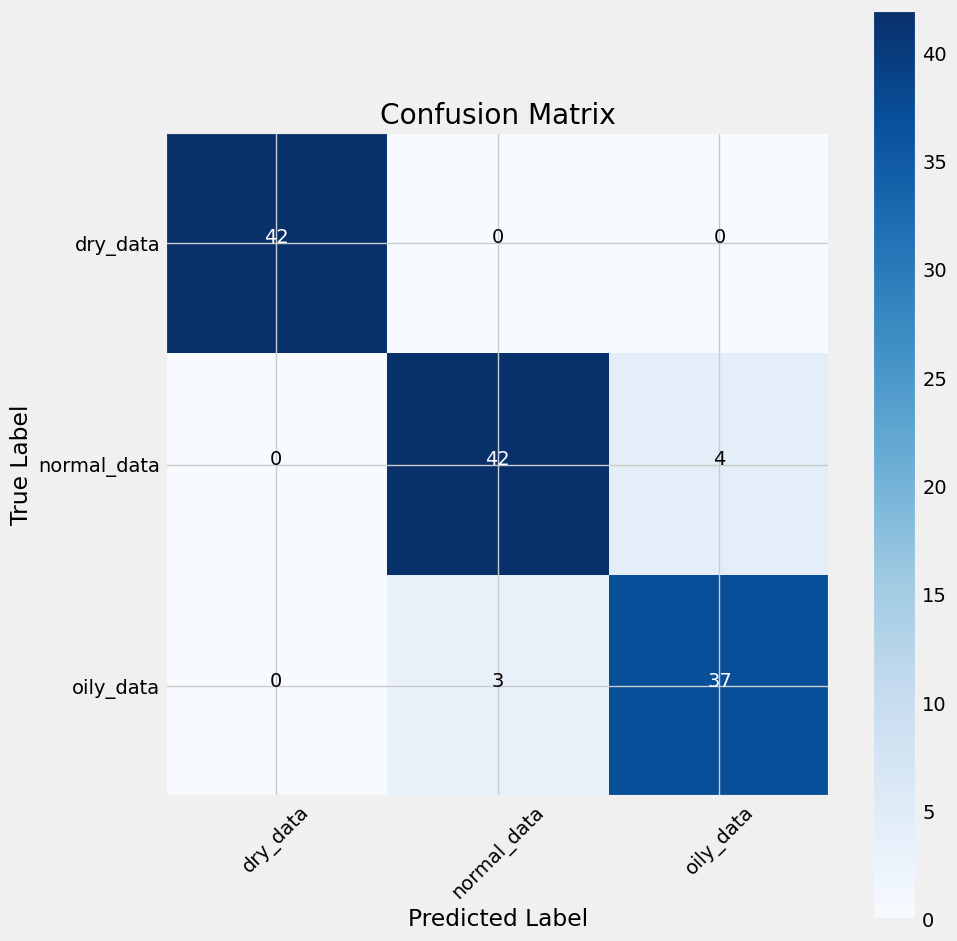

In [17]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))

In [18]:
model_name = model.input_names[0][:-6]
subject = 'SkinType'
acc = test_score[1] * 100
save_path = "/content/drive/MyDrive/SkintypeModel/4"

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as /content/drive/MyDrive/SkintypeModel/4/efficientnet_v2_b0-SkinType-96.25.h5
weights were saved as /content/drive/MyDrive/SkintypeModel/4/efficientnet_v2_b0-SkinType-weights.h5
